# Assessment of Countries by size and population:

In [2]:
import pandas as pd
import sqlite3
import requests
import lxml.html as lh
import os
import numpy as np
import math
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
from plotly import tools
import plotly.graph_objs as go
import matplotlib.pyplot as plt
init_notebook_mode(connected=True) # run at the start of every notebook
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

## Webscraping 

In [3]:
r = requests.get('http://www.worldometers.info/geography/alphabetical-list-of-countries/')

doc = lh.fromstring(r.text)

tr_elements = doc.xpath('//tr')

errors = 0
for  idx, T in enumerate(tr_elements):
    if len(T.getchildren()) != 5:## Since we know that the table has 5 columns, we are looking within
        print('error at')
        print(idx)
        errors+= 1
    else:
        pass
if errors == 0:
    print('No Errors, \nHere are the first 10 elements/rows of the new html list corresponding to the rows of the table\n')
print(tr_elements[:10])

print('\nEach row has 5 elements titled th or td, th = table header, td =table data\n===========================================================')

print('I am checking to see if the first and last rows of the table body contain all the proper data I want.\n')
tr_elements_tb = tr_elements[1:]
print(tr_elements_tb[0].text_content())
print(tr_elements_tb[-1].text_content())
# Looks like all the data including from the rear of the dataset is vital data, we don't have to
#worry about looping in data that is unnecessary
print('\nIt looks like the table contains no unnecessary information.\n=============================================================')
print('\nTesting a for loop to create a sqlite database:\n=============================================================')
for row in tr_elements_tb[:3]:
    print(row.getchildren())
    print(row[1].text_content())
    print('\n')

No Errors, 
Here are the first 10 elements/rows of the new html list corresponding to the rows of the table

[<Element tr at 0x7f1bf7ab2bd8>, <Element tr at 0x7f1bf7ab2368>, <Element tr at 0x7f1bf77cc048>, <Element tr at 0x7f1bf77cc098>, <Element tr at 0x7f1bf77cc0e8>, <Element tr at 0x7f1bf77cc138>, <Element tr at 0x7f1bf77cc188>, <Element tr at 0x7f1bf77cc1d8>, <Element tr at 0x7f1bf77cc3b8>, <Element tr at 0x7f1bf77cc408>]

Each row has 5 elements titled th or td, th = table header, td =table data
I am checking to see if the first and last rows of the table body contain all the proper data I want.

 1 Afghanistan 36,373,176 652,860 56 
 195 Zimbabwe 16,913,261 386,850 44 

It looks like the table contains no unnecessary information.

Testing a for loop to create a sqlite database:
[<Element td at 0x7f1bf7ab2278>, <Element td at 0x7f1bf77db048>, <Element td at 0x7f1bf77db098>, <Element td at 0x7f1bf77db0e8>, <Element td at 0x7f1bf77db138>]
Afghanistan


[<Element td at 0x7f1bf7ab2278

## Turning the data into a sqlite3 database:

In [4]:
db = sqlite3.connect(':memory:')
c = db.cursor()

_=c.execute("""
    CREATE TABLE IF NOT EXISTS COUNTRIES(Country, 
                            Population_2018,
                            Land_Area,
                            Pop_Density)
""")

for row in tr_elements_tb:
    c.execute("""
            INSERT INTO COUNTRIES(Country, 
                                  Population_2018,
                                  Land_Area,
                                  Pop_Density)
            VALUES(?,?,?,?)
    """, (row.getchildren()[1].text_content(), row.getchildren()[2].text_content(), row.getchildren()[3].text_content(), row.getchildren()[4].text_content()))
db.commit()

c.execute("""
    SELECT * FROM COUNTRIES
""")

print('This is the output of my sqlite Database:\n=================================================')
print(c.fetchmany(10))

This is the output of my sqlite Database:
[('Afghanistan', '36,373,176', '652,860', '56'), ('Albania', '2,934,363', '27,400', '107'), ('Algeria', '42,008,054', '2,381,740', '18'), ('Andorra', '76,953', '470', '164'), ('Angola', '30,774,205', '1,246,700', '25'), ('Antigua and Barbuda', '103,050', '440', '234'), ('Argentina', '44,688,864', '2,736,690', '16'), ('Armenia', '2,934,152', '28,470', '103'), ('Australia', '24,772,247', '7,682,300', '3'), ('Austria', '8,751,820', '82,409', '106')]


## Plotting from sqlite

In [5]:
# Pulling in the data from my database
c.execute("""
    SELECT Country, Population_2018, Land_Area, Pop_Density FROM COUNTRIES 
""")

Country = []
Pop     = []
La      = []
PD      = []

for row in c.fetchall():
    Country.append(row[0])
    Pop.append(int(row[1].replace(',', '').strip()))
    La.append(int(row[2].replace(',','').strip()))
    PD.append(int(row[3].replace(',','').strip()))

# Creating a dataframe out of all the rows from database
plot1 = {
    'Country': [],
    'Pop':     [],
    'PD':      [],
    'La':      []   
}
for row in Country:
     plot1['Country'].append(row)
for row in Pop:
    plot1['Pop'].append(row)
for row in PD:
    plot1['PD'].append(row)
for row in La:
    plot1['La'].append(row)
df1 = pd.DataFrame(plot1)

df1.iloc[186,0] = 'United States'

# Pulling in a seperate file for GDP per country, merging the dataframes to plot
rr = requests.get('http://statisticstimes.com/economy/countries-by-projected-gdp.php')

htmltext = lh.fromstring(rr.text)

gdp = htmltext.get_element_by_id('table_id') 

gdpbody = gdp[1].getchildren()

plot2 = {
    'Country' : [],
    'GDP'     : []
}
for i in gdpbody:
        plot2['Country'].append(i.getchildren()[0].text_content())
        plot2['GDP'].append(float(i.getchildren()[1].text_content().replace(',','').strip()))

df2=pd.DataFrame(plot2)

df3 = pd.merge(df1, df2, left_on = 'Country', right_on = 'Country')

df3['GdpPerCap'] = (df3['GDP']*1000000000) /df3['Pop']
#Mutiplied GDP by 1B since it is represented in billions

df4 = df3.copy()

# Creating sizes and texts  for my plot
hover_text = []
bubble_size = []
bubble_ref =[]

for index, row in df3.iterrows():
    hover_text.append(('Country: {Country}<br>'+
                      'Population (2018) : {Pop}<br>'+
                      'Population Density (P/Km²) : {PD}<br>'+
                      'Land Area (Km²) : {La}<br>'+ 
                       'GDP (per USD billions) : {GDP}<br>'+
                      'GDP per Cap : {GdpPerCap}<br>').format(Country=row['Country'],
                                                             Pop = row['Pop'],
                                                             PD = row['PD'],
                                                             La = row['La'],
                                                             GDP = row['GDP'],
                                                             GdpPerCap = row['GdpPerCap']
                                                                                                ))
    bubble_size.append(row['PD'])
    bubble_ref.append(math.sqrt(row['PD']))


df3['text']= hover_text
df3['size'] = bubble_size
df3['ref']=bubble_ref
sizeref = (max(df3['ref']))/350

### Looking individually at Country's GDP and Population:

When we examine both of the above plots, we can see

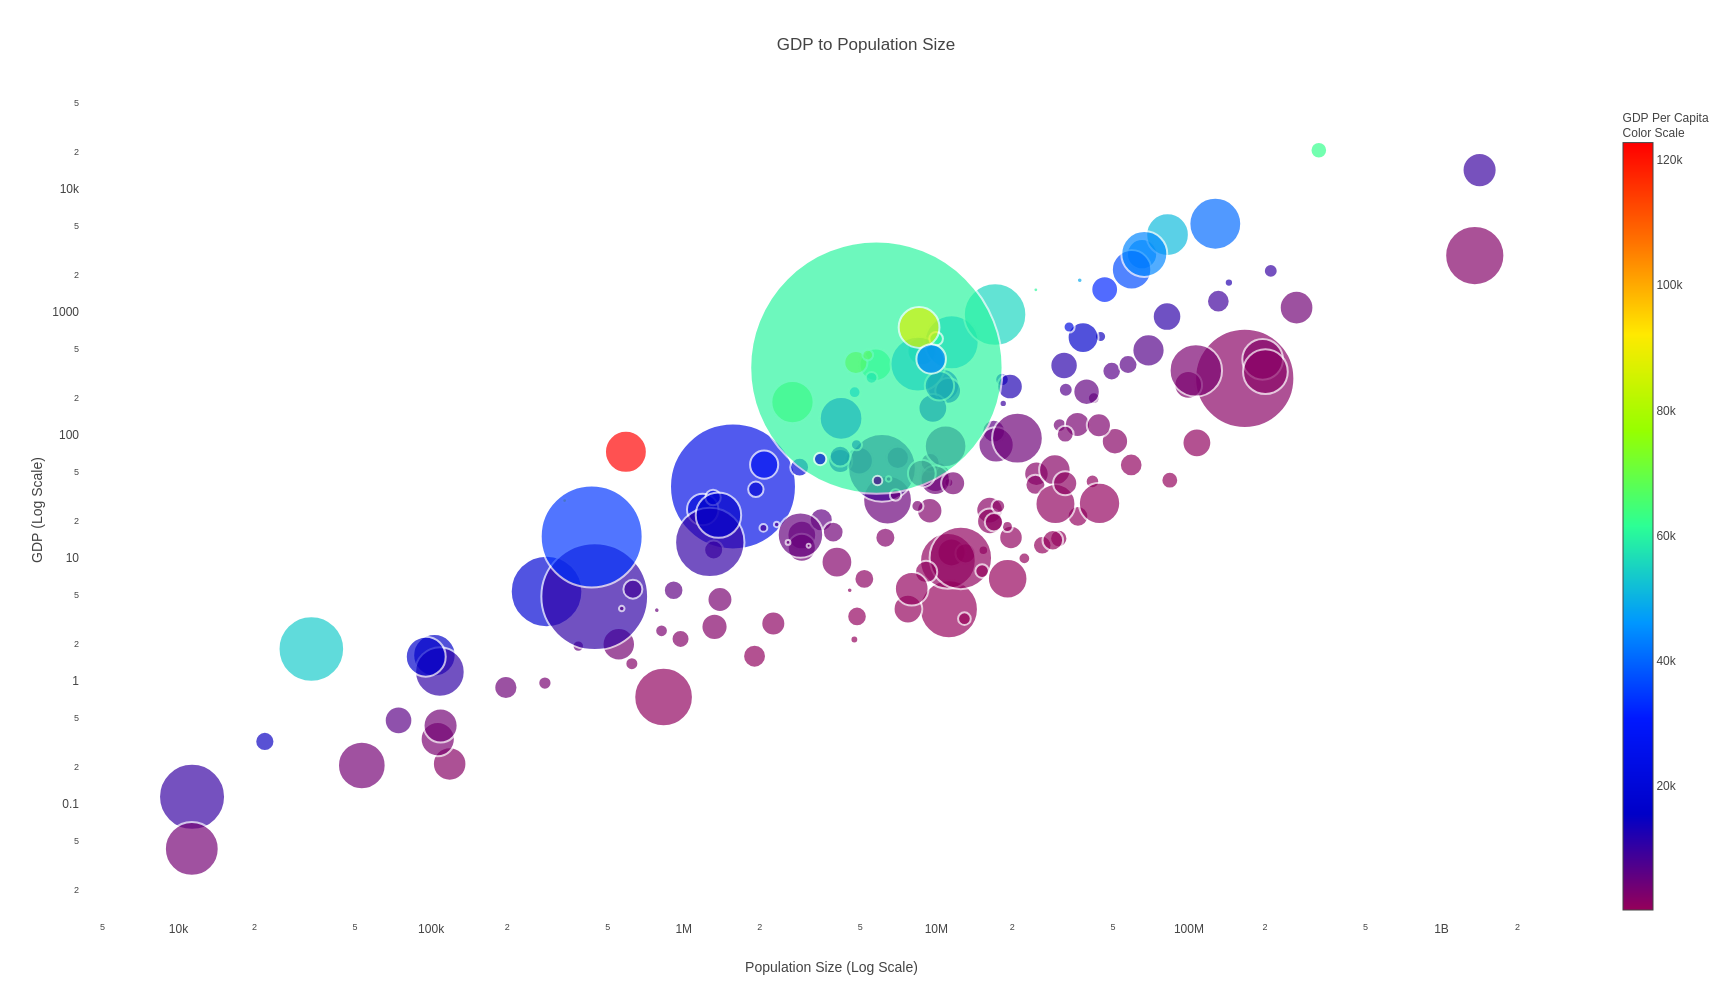

In [11]:
# Plotting GDP to poluation, size of the points are related to population density while color is related to land area of the country
PopToDen = go.Figure(
    data = [go.Scatter(
         x=df3.Pop,
         y=df3.GDP,
         mode='markers',
         text=df3.text,
         marker= dict(
         symbol='circle',
         sizemode='area',
         size = df3['size'],
         sizeref = sizeref,
         line= dict(
         width = 2
         ),
             color = df3.GdpPerCap,
              colorbar=dict(
                title='GDP Per Capita<br>Color Scale'
            ),
             colorscale = 'Rainbow',
             showscale = True,
             opacity=0.68
    ))],
    layout = go.Layout(
        height = 1000,
        width = 1600,
        hovermode = 'closest',
        title = 'GDP to Population Size',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis = dict(
            type = 'log',
            title = 'GDP (Log Scale)',
            showgrid = False
        ),
        xaxis = dict(
            type = 'log',
            title = 'Population Size (Log Scale)',
            showgrid=False
        )))
_=py.iplot(PopToDen, filename = 'Countries GDP to their Population Size')
iplot(PopToDen)

==========================================================

The plot above represents 4 dimensions of data. The data points represent individual countries, where the size is scaled to a countries popualtion density. The y axis represents GDP, and the x axis represents Population size. The colors of the points are representative of GDP per Capita for each country. This plot is interesting because we see a clear correlation between the size of a population and GDP per country. Things get even more interesting though when we look at relative population densities. The countries with the highest populations are actually not the highest in population densities. For highest popualtion densities, we see countries like singapore and others of similar size clustering towards the middle of the graph. This could be expected because unlike population, population density is a factor of a countries total population by their total land area. While there is a clear relationship between population and GDP, a distinct relationship between the density of one's population and their respective GDP is harder to establish. If you think in terms of production, For the last century, most countries along the upper right of the plot such as the United States, Germany, China, India have all achieved massive gains in GDP due to industrialization. To increase capital gains in industrialization, you need substantive land area to continue to develop industry. While outlier countries like Singapore and Luxemborg have the technology to indsutrialize and increase their GDP, they are severely limited when it comes to the necessary land area to continue development. This also drives an increase in population density, given the massive size of Singapores population density. Another train of thought for the development of these outliers GDP could be related to the progress of technology. With the progress of technology, this gives opportunity for smaller countries like Luxemborg, and Singapore to increase their GDP, and therefore GDP per Capita. The colors and sizes of the graph make it much easier to spot outliers in the trend of GDP increase by Population increase. It is clear that an increase in a Country's GDP, does not indicate a clear increase in the GDP per capita for that country. While a country may have seemingly high GDP, an individual may not necessarily be better off within a country with a large GDP, rather an individual from an outlier country like luxemborg will have more share of a countries wealth than an individual in China, or India.(Dependent on current political status. i.e. Democracy, or alternative form of government)

It is important to note, that while there is a relationship, we cannot call it a linear relationship because of the log scale of the axes.

=========================================================

### Correlation between variables:
 

This is the Pearson correlation coefficient for the variables Population Density and Population size:
0.5833260930164148
This is a heatmap visual of the correlation between the  different variables of the dataframe.



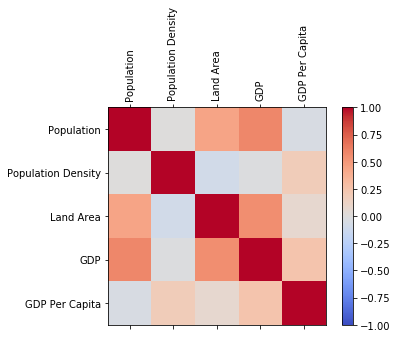

In [7]:
#Looking at the correlation between the two features that are lineraly related.
def pear_cor(x, y):
    
    corr_mat = np.corrcoef(x,y)
    
    return corr_mat [0,1]
pr= pear_cor(df3['GDP'],df3['Pop'])
print('This is the Pearson correlation coefficient for the variables Population Density and Population size:')
print(pr)
print('==========================================================================')

# Looking at the correlations between all variables with a heat map
print('This is a heatmap visual of the correlation between the  different variables of the dataframe.\n==============================================================================================\n')
corr = df4.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(['Population','Population Density','Land Area', 'GDP', 'GDP Per Capita'])
ax.set_yticklabels(['Population','Population Density','Land Area', 'GDP', 'GDP Per Capita'])
plt.show()


In [8]:
# Similar to the plot above.
print('This is the table of the correlation coefficients visualized above:\n====================================================================')
print(df4.corr())

This is the table of the correlation coefficients visualized above:
                Pop        PD        La       GDP  GdpPerCap
Pop        1.000000  0.006581  0.444058  0.583326  -0.040472
PD         0.006581  1.000000 -0.083728 -0.010972   0.185479
La         0.444058 -0.083728  1.000000  0.549164   0.077867
GDP        0.583326 -0.010972  0.549164  1.000000   0.244645
GdpPerCap -0.040472  0.185479  0.077867  0.244645   1.000000


In [9]:
stop = input('Enter Y if you want to close the DB: ')

if stop == 'Y':
    c.close()
    db.close()
else: 
    pass